In [1]:
!pip install contractions

In [2]:
##nlp dependencies
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [3]:
#viz
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import re
import contractions
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [5]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
def clean_text(q,stem=False,stopwords=None):
  q = str(q).lower().strip()
  q = contractions.fix(q) ## correcting the contractions
  q = re.sub(r"https?://\S+|www\.\S+", "", q) ## remove the urls from string
  html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")  ##removing the html tags
  q = re.sub(html, "", q)
  #replace certain special characters
  q = q.replace('%', ' percent')
  q = q.replace('$', ' dollar')
  q = q.replace('₹', ' rupee ')
  q = q.replace('@', ' at')
  q = q.replace('€', ' euro')
  q = q.replace('[math]','')
  q = re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", q) ##puntuation
  if stem:
    q = " ".join([stemmer.stem(word) for word in q.split(" ")])

  if stopwords:
    q = " ".join([w for w in q.split(" ") if w not in stopwords])
  return q

In [8]:
df=pd.read_csv('/content/sample_adv_features.csv',nrows=10000)
df =df.drop(['Unnamed: 0.1','Unnamed: 0','qid1','qid2'],axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10000 non-null  int64  
 1   question1             10000 non-null  object 
 2   question2             9999 non-null   object 
 3   is_duplicate          10000 non-null  int64  
 4   q1_len                10000 non-null  int64  
 5   q2_len                10000 non-null  int64  
 6   q1_num_words          10000 non-null  int64  
 7   q2_num_words          10000 non-null  int64  
 8   num_common_words      10000 non-null  int64  
 9   num_total_words       10000 non-null  int64  
 10  word_share            10000 non-null  float64
 11  cwc_min               10000 non-null  float64
 12  cwc_max               10000 non-null  float64
 13  csc_min               10000 non-null  float64
 14  csc_max               10000 non-null  float64
 15  ctc_min             

In [8]:
def preprocess(df, stem=False,stopwords=None):
  df.question1 = df.question1.apply(clean_text)
  df.question2 = df.question2.apply(clean_text)
  return df

In [9]:
def get_data_splits(X, y, train_size=0.7):
    """Generate balanced data splits."""
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

## Base lines
1. Random
2. Rule Based
3. Simple ML model

**Random Prediction**

motivation: We want to know what random (chance) performance looks like. All of our efforts should be well above this baseline.

In [10]:
import random
import numpy as np
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)

In [11]:
from sklearn.metrics import precision_recall_fscore_support,accuracy_score

In [14]:
df=pd.read_csv('/content/sample_adv_features.csv',nrows=10000)
df =df.drop(['Unnamed: 0.1','Unnamed: 0','qid1','qid2'],axis=1)
df = preprocess(df)
X= df.drop('is_duplicate' ,axis=1)
y = df.is_duplicate
X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(X,y)

In [15]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=1, size=len(y_test))
print (y_pred.shape)
print (y_pred[0:5])

(1500,)
[0 0 0 0 0]


In [16]:
# Evaluate
import json
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.252004,
  "recall": 0.502,
  "f1": 0.33555792276964047
}


In [17]:
from collections import Counter
# Class frequencies
p = [Counter(y_test)[index]/len(y_test) for index in range(2)]
p  #probability of each class if we predict randomly

[0.502, 0.498]

In [18]:
# Generate weighted random predictions
y_pred = np.random.choice(a=range(2), size=len(y_test), p=p)

In [19]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.5066463719306731,
  "recall": 0.5066666666666667,
  "f1": 0.5066421074902525
}


limitations: we didn't use the tokens in our input to affect our predictions so nothing was learned.

**Rule Based predictions**

motivation: we want to use signals in our inputs (along with domain expertise and auxiliary data) to determine the labels.

In [20]:
df[['word_share','is_duplicate']].groupby(by='is_duplicate').mean()

,word_share
is_duplicate,
0,0.208022
1,0.305389


In [21]:
def get_class(q1,q2):
  is_duplicate = 0
  q1_words = set(q1.split(' '))
  q2_words = set(q2.split(' '))
  total_words = len(set(str(q1+q2).split(' ')))
  com_words = len(q1_words.intersection(q2_words))
  word_share_percent = com_words/total_words
  if word_share_percent > 0.35:    #domain knwoledge if word share percent is more than 35 it is more likely the question is duplicate
     is_duplicate = 1
  return is_duplicate

In [22]:
q1='what are the best pics clicked on a phone'
q2 = 'what are some of the best photos taken from a cell phone'
get_class(q1,q2)

1

In [23]:
y_pred = []
for q1 , q2 in zip(X_test.question1.to_list(),X_test.question2.to_list()):
  _class = get_class(q1,q2)
  y_pred.append(_class)

In [24]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.6621615384615385,
  "recall": 0.662,
  "f1": 0.6618660871861981
}


limitations: we failed to generalize or learn any implicit patterns to predict the labels because we treat the tokens in our input as isolated entities.

Vectorization

representation: use term frequency-inverse document frequency (TF-IDF) to capture the significance of a token to a particular input with respect to all the inputs, as opposed to treating the words in our input text as isolated tokens.

architecture: we want our model to meaningfully extract the encoded signal to predict the output labels.

In [25]:
df=pd.read_csv('/content/sample_adv_features.csv',nrows=10000)
df =df.drop(['Unnamed: 0.1','Unnamed: 0','qid1','qid2'],axis=1)
df = preprocess(df,stem=True,stopwords=STOPWORDS)
X= df.drop('is_duplicate' ,axis=1)
y = df.is_duplicate

In [26]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(X,y)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
MAX_FEATURE = 3000
vectorizer = TfidfVectorizer()

In [28]:
vectorizer = TfidfVectorizer(max_features=MAX_FEATURE)
train_que = list(X_train.question1) + list(X_train.question2)
tr_q1_arr,tr_q2_arr=np.vsplit(vectorizer.fit_transform(train_que).toarray(),2)
tr_qdf1 = pd.DataFrame(tr_q1_arr,index=X_train.index)
tr_qdf2 = pd.DataFrame(tr_q2_arr,index=X_train.index)
train_qdf = pd.concat([tr_qdf1,tr_qdf2],axis=1)
cols = ['col' + str(i) for i in range(0,train_qdf.shape[1])]
train_qdf.columns = cols
X_train = pd.concat([train_qdf,X_train],axis=1)

In [29]:
val_que = list(X_val.question1) + list(X_val.question2)
val_q1_arr,val_q2_arr=np.vsplit(vectorizer.transform(val_que).toarray(),2)
val_qdf1 = pd.DataFrame(val_q1_arr,index=X_val.index)
val_qdf2 = pd.DataFrame(val_q2_arr,index=X_val.index)
val_qdf = pd.concat([val_qdf1,val_qdf2],axis=1)
cols = ['col' + str(i) for i in range(0,val_qdf.shape[1])]
val_qdf.columns = cols
X_val = pd.concat([val_qdf,X_val],axis=1)

In [30]:
test_que = list(X_test.question1) + list(X_test.question2)
test_q1_arr,test_q2_arr=np.vsplit(vectorizer.transform(test_que).toarray(),2)
test_qdf1 = pd.DataFrame(test_q1_arr,index=X_test.index)
test_qdf2 = pd.DataFrame(val_q2_arr,index=X_test.index)
test_qdf = pd.concat([test_qdf1,test_qdf2],axis=1)
cols = ['col' + str(i) for i in range(0,test_qdf.shape[1])]
test_qdf.columns = cols
X_test = pd.concat([test_qdf,X_test],axis=1)

In [35]:
# data1 = pd.concat([X_train,X_val,X_test] ,axis=0)
# data2 = pd.concat([y_train,y_val,y_test],axis=0)
# final = pd.concat([data1,data2],axis=1)

(10000, 8025)

In [31]:
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [3515 3485],
class weights: {0: 0.0002844950213371266, 1: 0.00028694404591104734}


In [32]:
X_train = X_train.drop(['question1','question2'],axis=1)
X_test = X_test.drop(['question1','question2'],axis=1)
X_val = X_val.drop(['question1','question2'],axis=1)

**Machine Learning**

In [33]:
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support
import pickle

In [35]:
model=pickle.load(open('model.pkl','rb'))

In [63]:
# Initialize model
model = RandomForestClassifier(max_features='log2', min_samples_split=3,
                       n_estimators=264)

In [64]:
# Train model
num_epochs = 50
for epoch in range(num_epochs):
    # Training
    model.fit(X_train, y_train)

    # Evaluation
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_loss: {train_loss:.5f}, "
            f"val_loss: {val_loss:.5f}"
        )

Epoch: 00 | train_loss: 0.16352, val_loss: 0.47723
Epoch: 10 | train_loss: 0.16375, val_loss: 0.47759
Epoch: 20 | train_loss: 0.16399, val_loss: 0.47722
Epoch: 30 | train_loss: 0.16488, val_loss: 0.47823
Epoch: 40 | train_loss: 0.16440, val_loss: 0.47942


In [36]:
# Evaluate
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

{
  "precision": 0.7483672122913956,
  "recall": 0.7313333333333333,
  "f1": 0.7268615797738225
}


In [37]:
p=np.array(list(X_test.iloc[1])).reshape(1,-1)
model.predict(p)

array([1])

In [38]:
{'not_duplicate':model.predict_proba(p)[0][0],'duplicate':model.predict_proba(p)[0][1]}

{'not_duplicate': 0.47316919191919193, 'duplicate': 0.526830808080808}

In [39]:
# Determine first quantile softmax score for the correct class (on validation split)
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)], q=0.50)  # Q1
threshold

0.7023358585858586

In [40]:
# Custom predict function
def custom_predict(y_prob, threshold, index):
    """Custom predict function that defaults
    to an index if conditions are not met."""
    y_pred = [np.argmax(p) if max(p) > threshold else index for p in y_prob]
    return np.array(y_pred)

**Evaluation**

In [42]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [74]:
y_prob = model.predict_proba(X_test)
# y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=0)
y_pred = model.predict(X_test)

**Coarse Grained**

In [75]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="binary")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

{
    "precision": 0.6825902335456475,
    "recall": 0.8607764390896921,
    "f1": 0.7613972764949675,
    "num_samples": 1500.0
}


**Fine Grained**

Inspecting these coarse-grained, overall metrics is a start but we can go deeper by evaluating the same fine-grained metrics at the categorical feature levels.

**Confusion Matrix**

<Axes: >

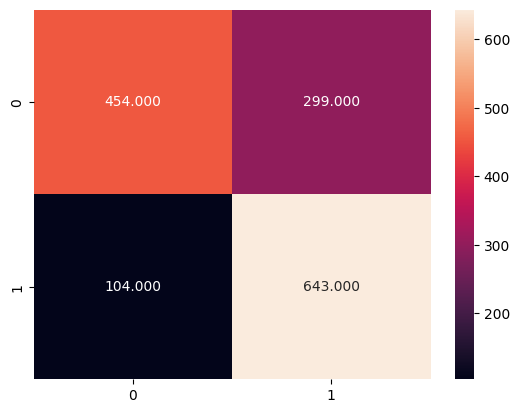

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
con=confusion_matrix(y_test,y_pred)
sns.heatmap(con,annot=True,fmt=".3f")

**Confident learning**

In [68]:
!pip install cleanlab==1.0.1 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.5 MB/s eta 0:00:00


In [69]:
import cleanlab
from cleanlab.pruning import get_noise_indices

In [78]:
# Determine potential labeling errors
label_error_indices = get_noise_indices(
            s=y_test,
            psx=y_prob,
            sorted_index_method="self_confidence",
            verbose=0)

In [79]:
num_samples = 5
for index in label_error_indices[:num_samples]:
    # print ("que1:", X_test.iloc[index][8000:10])
    # print ("que2:", X_test.iloc[index][8000:10])
    print ("true:", y_test.iloc[index])
    print ("pred:", y_pred[index])

true: 1
pred: 0
true: 0
pred: 1
true: 1
pred: 0
true: 0
pred: 1
true: 1
pred: 0
